In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from gnn_utils.gnn_model_utils import load_trained_gnn_model
from gnn_utils.inverse_design_utils import optimize_input_for_target

import sys
sys.path.append("..")   # one level up from notebooks/
from gnn_utils.gnn_model_utils import (
    build_unified_err_graph,
    load_graph,
    mask_data,
    GCN
)
from gnn_utils.gnn_train import train_gnn

csv_paths = ["../Data/gnn_camb_dataset.csv", 
             "../Data/gnn_class_dataset.csv",
             "../Data/gnn_emcee_dataset.csv"]

feature_cols = [["AccuracyBoost", "lAccuracyBoost", "lSampleBoost"],
                ["tol_background", "tol_thermo"],
                ["n_walkers", "n_steps"]]

graph_paths = ["../Data/camb_graph.pt",
               "../Data/class_graph.pt",
               "../Data/emcee_graph.pt"]

labels = ['camb', 'class', 'emcee']

Loaded trained GNN model from: ../Data/gnn_camb_model.pt
Loaded graph from: ../Data/camb_graph.pt

=== MODEL EVALUATION ===
ERROR PREDICTION:
  MSE: 0.000000
  MAE: 0.000004
  R² : 0.896569

CPU TIME PREDICTION:
  MSE: 8.701452
  MAE: 1.718814
  R² : 0.965056


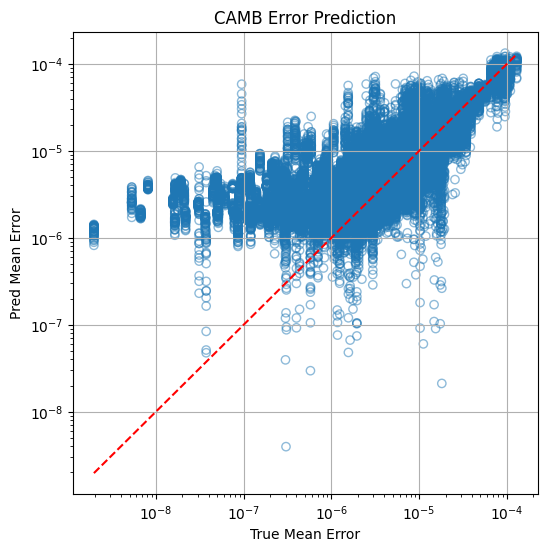

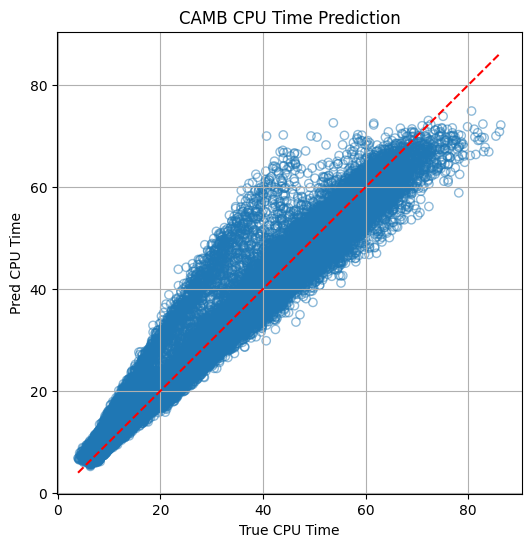

In [19]:
# --------------------------------------------------------
# Choose which model to evaluate
# --------------------------------------------------------
choice = 0  # 0=camb, 1=class, 2=emcee
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = f"../Data/gnn_{labels[choice]}_model.pt"
graph_path = graph_paths[choice]

model_loaded, data, scaler_x, scaler_y = load_trained_gnn_model(
    model_path=model_path,
    graph_path=graph_path,
    device=device
)

# --------------------------------------------------------
# Step 3: Make predictions (scaled + original)
# --------------------------------------------------------
with torch.no_grad():
    pred_scaled = model_loaded(data).cpu().numpy()
    pred_orig = scaler_y.inverse_transform(pred_scaled)

true_orig = data.orig_targets.cpu().numpy()

##remove outliers
idx = np.where(true_orig[:,0] > 1e-16)[0]
true_err = true_orig[idx,0]; true_cpu = true_orig[idx,1];
pred_err = pred_orig[idx,0]; pred_cpu = pred_orig[idx,1];

# --------------------------------------------------------
# Step 4: Compute metrics
# --------------------------------------------------------
mse_err = mean_squared_error(true_err, pred_err)
mae_err = mean_absolute_error(true_err, pred_err)
r2_err  = r2_score(true_err, pred_err)

mse_cpu = mean_squared_error(true_cpu, pred_cpu)
mae_cpu = mean_absolute_error(true_cpu, pred_cpu)
r2_cpu  = r2_score(true_cpu, pred_cpu)

print("\n=== MODEL EVALUATION ===")
print(f"ERROR PREDICTION:")
print(f"  MSE: {mse_err:.6f}")
print(f"  MAE: {mae_err:.6f}")
print(f"  R² : {r2_err:.6f}")

print(f"\nCPU TIME PREDICTION:")
print(f"  MSE: {mse_cpu:.6f}")
print(f"  MAE: {mae_cpu:.6f}")
print(f"  R² : {r2_cpu:.6f}")

# --------------------------------------------------------
# Step 5: Optional plots — Pred vs True
# --------------------------------------------------------
plt.figure(figsize=(6,6)) 
plt.scatter(true_err, pred_err, alpha=0.5, facecolors='none', edgecolors='tab:blue')
plt.plot([true_err.min(), true_err.max()],
         [true_err.min(), true_err.max()],
         'r--')
plt.xlabel("True Mean Error")
plt.ylabel("Pred Mean Error")
plt.xscale('log')
plt.yscale('log')
plt.title(f"{labels[choice].upper()} Error Prediction")
plt.grid(True)
plt.savefig(labels[choice]+"-error.png")
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(true_cpu, pred_cpu, alpha=0.5, facecolors='none', edgecolors='tab:blue')
plt.plot([true_cpu.min(), true_cpu.max()],
         [true_cpu.min(), true_cpu.max()],
         'r--')
plt.xlabel("True CPU Time")
plt.ylabel("Pred CPU Time")
plt.title(f"{labels[choice].upper()} CPU Time Prediction")
plt.grid(True)
plt.savefig(labels[choice]+"-cpu.png")
plt.show()


In [26]:
target_error = 5e-6
num_steps=1200
lr=0.05
## Inverse optimum parameters
label = labels[choice]
if label == "camb":
    bounds = {0:(1.0,3.0), 1:(1.0,3.0), 2:(1.0,3.0)}
    integer_indices = None

elif label == "class":
    bounds = {0:(1e-10,1e-6), 1:(1e-6,1e-4)}
    integer_indices = None

elif label == "emcee":
    bounds = {0:(50,500), 1:(200,5000)}
    integer_indices = [0,1]

X_orig, X_norm, y_pred_orig = optimize_input_for_target(
        model=model_loaded,scaler_x=scaler_x,scaler_y=scaler_y,
        desired_error_orig=target_error,  # cpu_time auto-optimized
        feature_dim=data.x.shape[1],
        num_steps=num_steps, lr=lr, bounds_orig=bounds,
        integer_indices=integer_indices, device='cpu')

# ------------------------------------------
# Print results
# ------------------------------------------
print("\n=== INVERSE DESIGN: MODE 2 (Minimize CPU Time given desired error) ===")
print(f"Desired error: {target_error}")
print(f"Label: {label.upper()}")

feature_cols_dict = {
    "camb": ["AccuracyBoost", "lAccuracyBoost", "lSampleBoost"],
    "class": ["tol_background", "tol_thermo"],
    "emcee": ["n_walkers", "n_steps"]
}

print("\nSuggested Input Settings:")
for name, val in zip(feature_cols_dict[label], X_orig[0]):
    if integer_indices and feature_cols_dict[label].index(name) in integer_indices:
        print(f"{name}: {int(val)}")
    else:
        print(f"{name}: {val:.6f}")

print("\nPredicted [error, cpu_time]:")
print(y_pred_orig[0])
opt_err = y_pred_orig[0][0]
opt_cpu = y_pred_orig[0][1]

[inverse] step 0, loss=-0.014762, error=-0.4523, cpu=-0.1476
[inverse] step 100, loss=-0.090466, error=-0.3722, cpu=-0.9079
[inverse] step 200, loss=-0.090472, error=-0.3738, cpu=-0.9074
[inverse] step 300, loss=-0.090478, error=-0.3738, cpu=-0.9075
[inverse] step 400, loss=-0.090477, error=-0.3744, cpu=-0.9073
[inverse] step 500, loss=-0.090472, error=-0.3715, cpu=-0.9082
[inverse] step 600, loss=-0.090461, error=-0.3695, cpu=-0.9089
[inverse] step 700, loss=-0.090483, error=-0.3737, cpu=-0.9075
[inverse] step 800, loss=-0.090481, error=-0.3737, cpu=-0.9075
[inverse] step 900, loss=-0.090480, error=-0.3738, cpu=-0.9075
[inverse] step 1000, loss=-0.090478, error=-0.3736, cpu=-0.9075
[inverse] step 1100, loss=-0.090476, error=-0.3741, cpu=-0.9074

=== INVERSE DESIGN: MODE 2 (Minimize CPU Time given desired error) ===
Desired error: 5e-06
Label: CAMB

Suggested Input Settings:
AccuracyBoost: 1.469543
lAccuracyBoost: 2.147313
lSampleBoost: 1.000000

Predicted [error, cpu_time]:
[5.3412919

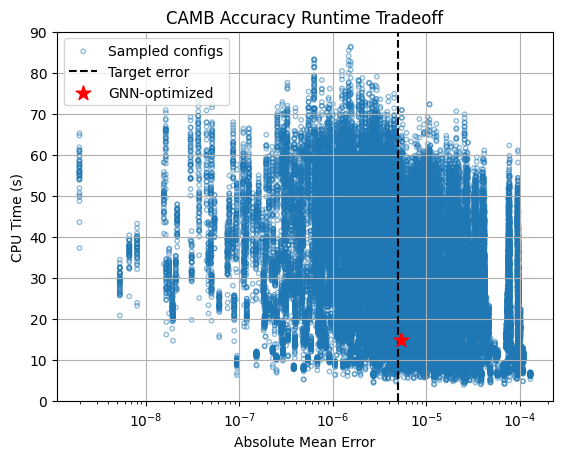

In [33]:
# Inverse design Plot
df = data['raw_df']
cpu_df = df['cpu_time']
error_df = df['error']
# Eliminating outliers
error_idx = np.where(df['error'] > 1e-16)[0]


plt.scatter(error_df[error_idx], cpu_df[error_idx],s=10., alpha=0.5, zorder=1,
            facecolors='none', edgecolors='tab:blue', label="Sampled configs")
plt.axvline( target_error,color="black",linestyle="--",label="Target error", zorder=2)
plt.scatter( opt_err, opt_cpu, color="red", s=120, marker="*", label="GNN-optimized", zorder=3)
# plt.annotate("Optimized", (opt_err, opt_cpu),  xytext=(10, 10),
#              textcoords="offset points", arrowprops=dict(arrowstyle="->"))
plt.xlabel(r'Absolute Mean Error')
plt.ylabel(r'CPU Time (s)')
plt.grid()
plt.xscale('log')
plt.ylim(0,90)
plt.legend()
plt.title('CAMB Accuracy Runtime Tradeoff')
plt.savefig(labels[choice]+'-Error-vs-CPU.png')

In [ ]:
df = pd.read_csv(csv_paths[choice])

In [ ]:
abs_error = np.abs(df['error'])
cpu_df = df['cpu_time']
error_df = np.where(abs_error > 1e-17)[0]
target_error = 5e-6





In [ ]:
pred_error = pred_orig[:, 0]; pred_cpu   = pred_orig[:, 1];
mask = np.abs(pred_error) <= target_error
best_idx = np.argmin(pred_cpu[mask])
# translate back to original indices
candidate_indices = np.where(mask)[0]
opt_idx = candidate_indices[best_idx]

opt_error = pred_error[opt_idx]
opt_cpu   = pred_cpu[opt_idx]

In [ ]:
mask

In [ ]:
pred_error[mask]

In [ ]:
np.argmin(np.abs(true_orig[:,0]))

In [ ]:
true_orig[68858,0]

In [5]:
data['raw_df']

,AccuracyBoost,lAccuracyBoost,lSampleBoost,cpu_time,error,std
0,1.0,1.05,1.25,3.925241,2.504380e-05,2.001205e-04
1,1.0,1.00,1.60,4.012492,1.209248e-05,2.336773e-04
2,1.0,1.00,2.35,4.245082,1.209248e-05,2.336773e-04
3,1.0,1.05,1.40,4.560018,2.504380e-05,2.001205e-04
4,1.0,1.00,1.85,5.024301,1.209248e-05,2.336773e-04
...,...,...,...,...,...,...
68916,3.0,3.00,2.35,55.708379,1.672721e-18,5.888346e-17
68917,3.0,3.00,2.40,56.431807,1.672721e-18,5.888346e-17
68918,3.0,3.00,2.60,55.268643,1.672721e-18,5.888346e-17
68919,3.0,3.00,3.00,52.774130,1.672721e-18,5.888346e-17


In [16]:
idx = np.where(true_orig[:,0] > 1e-17)[0]
len(idx)

68880